# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction-to" data-toc-modified-id="Introduction-to-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction to</a></div><div class="lev2 toc-item"><a href="#What's-Julia?" data-toc-modified-id="What's-Julia?-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>What's Julia?</a></div><div class="lev2 toc-item"><a href="#R-is-great,-but..." data-toc-modified-id="R-is-great,-but...-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>R is great, but...</a></div><div class="lev2 toc-item"><a href="#Gibbs-sampler-example-by-Doug-Bates" data-toc-modified-id="Gibbs-sampler-example-by-Doug-Bates-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Gibbs sampler example by Doug Bates</a></div><div class="lev2 toc-item"><a href="#Learning-resources" data-toc-modified-id="Learning-resources-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Learning resources</a></div><div class="lev2 toc-item"><a href="#Julia-REPL-(Read-Evaluation-Print-Loop)" data-toc-modified-id="Julia-REPL-(Read-Evaluation-Print-Loop)-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Julia REPL (Read-Evaluation-Print-Loop)</a></div><div class="lev2 toc-item"><a href="#Seek-help" data-toc-modified-id="Seek-help-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Seek help</a></div><div class="lev2 toc-item"><a href="#Which-Editor/IDE?" data-toc-modified-id="Which-Editor/IDE?-17"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Which Editor/IDE?</a></div><div class="lev2 toc-item"><a href="#Julia-package-system" data-toc-modified-id="Julia-package-system-18"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Julia package system</a></div><div class="lev2 toc-item"><a href="#Calling-R-from-Julia" data-toc-modified-id="Calling-R-from-Julia-19"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Calling R from Julia</a></div><div class="lev2 toc-item"><a href="#Some-basic-Julia-code" data-toc-modified-id="Some-basic-Julia-code-110"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>Some basic Julia code</a></div><div class="lev2 toc-item"><a href="#Random-numbers" data-toc-modified-id="Random-numbers-111"><span class="toc-item-num">1.11&nbsp;&nbsp;</span>Random numbers</a></div><div class="lev2 toc-item"><a href="#Timing-and-benchmark" data-toc-modified-id="Timing-and-benchmark-112"><span class="toc-item-num">1.12&nbsp;&nbsp;</span>Timing and benchmark</a></div><div class="lev2 toc-item"><a href="#Machine-information" data-toc-modified-id="Machine-information-113"><span class="toc-item-num">1.13&nbsp;&nbsp;</span>Machine information</a></div>

# Introduction to

<img src="./julia_logo.png" alt="Julia toolchain" style="width: 400px;"/>

## What's Julia?

> Julia is a high-level, high-performance dynamic programming language for technical computing, with syntax that is familiar to users of other technical computing environments

* Started in 2009. First public release in 2012. 
  - Creators: Jeff Bezanson, Alan Edelman, Stefan Karpinski, Viral Shah
  - Current release v0.6.4
  - v1.0 is staged to release in 2018

* Aim to solve the notorious **two language problem**:
    - Prototype code goes into high-level languages like R/Python, production code goes into low-level language like C/C++
> Walks like Python. Runs like C.

* Write high-level, abstract code that closely resembles mathematical formulas
    - yet produces fast, low-level machine code that has traditionally only been generated by static languages.
    
<img src="./julia_vs_otherlang.png" align="center" width="600"/>    

* Julia is more than just "Fast R" or "Fast Matlab"
    - Performance comes from features that work well together.  
    - You can't just take the magic dust that makes Julia fast and sprinkle it on [language of choice]

## R is great, but...

* It's not meant for high performance computing
  - http://adv-r.had.co.nz/Performance.html
    - Section on performance starts with "Why is R slow?" 

* Deficiencies in the core language 
  - Many fixed with packages (`devtools`, `roxygen2`, `Matrix`, `tidyverse`)
  - Others harder to fix (R uses an old version of BLAS)
  - Some impossible to fix (clunky syntax, poor design choices)

* Only 6 active developers left (out of 20 R-Core members)
  - JuliaLang organization has 74 members, with 567 total contributors (as of 3/3/17)
    - https://github.com/JuliaLang/julia/graphs/contributors

* Doug Bates (member of R-Core, `Matrix` and `lme4`)
    - Getting Doug on board was a big win for statistics with Julia, as he brought a lot of knowledge about the history of R development and design choices
    
    > As some of you may know, I have had a (rather late) mid-life crisis and run off with another language called Julia.   
    >
    > -- <cite>Doug Bates (on the `knitr` Google Group)</cite>

## Gibbs sampler example by Doug Bates

* An example from Dr. Doug Bates's slides [Julia for R Programmers](http://www.stat.wisc.edu/~bates/JuliaForRProgrammers.pdf).

* The task is to create a Gibbs sampler for the density  
$$
f(x, y) = k x^2 exp(- x y^2 - y^2 + 2y - 4x), x > 0
$$
using the conditional distributions
$$
\begin{eqnarray*}
  X | Y &\sim& \Gamma \left( 3, \frac{1}{y^2 + 4} \right) \\
  Y | X &\sim& N \left(\frac{1}{1+x}, \frac{1}{2(1+x)} \right).
\end{eqnarray*}
$$

* **R solution**. The `RCall.jl` package allows us to execute R code without leaving the `Julia` environment. We first define an R function `Rgibbs()`.

In [1]:
# Pkg.add("RCall")
using RCall

R"""
library(Matrix)
Rgibbs <- function(N, thin) {
  mat <- matrix(0, nrow=N, ncol=2)
  x <- y <- 0
  for (i in 1:N) {
    for (j in 1:thin) {
      x <- rgamma(1, 3, y * y + 4) # 3rd arg is rate
      y <- rnorm(1, 1 / (x + 1), 1 / sqrt(2 * (x + 1)))
    }
    mat[i,] <- c(x, y)
  }
  mat
}
"""

RCall.RObject{RCall.ClosSxp}
function (N, thin) 
{
    mat <- matrix(0, nrow = N, ncol = 2)
    x <- y <- 0
    for (i in 1:N) {
        for (j in 1:thin) {
            x <- rgamma(1, 3, y * y + 4)
            y <- rnorm(1, 1/(x + 1), 1/sqrt(2 * (x + 1)))
        }
        mat[i, ] <- c(x, y)
    }
    mat
}


and then generate a sample of size 10,000 with a thinning of 500

In [2]:
R"""
Rgibbs(100, 5); # warm-up
system.time(Rgibbs(10000, 500))
"""

RCall.RObject{RCall.RealSxp}
   user  system elapsed 
 20.832   4.001  24.860 


* **Julia solution**. This is a Julia function for the same Gibbs sampler:

In [3]:
using Distributions

function jgibbs(N, thin)
    mat = zeros(N, 2)
    x = y = 0.0
    for i in 1:N
        for j in 1:thin
            x = rand(Gamma(3, 1 / (y * y + 4)))
            y = rand(Normal(1 / (x + 1), 1 / sqrt(2(x + 1))))
        end
        mat[i, 1] = x
        mat[i, 2] = y
    end
    mat
end

jgibbs (generic function with 1 method)

Generate the same sample. How long does it take?

In [4]:
jgibbs(100, 5); # warm-up
@elapsed jgibbs(10000, 500)

0.348287413

We see ~50 fold speed up of `Julia` over `R` on this example, **without extra coding effort**!

## Learning resources

0. [Intro to Julia](https://www.youtube.com/watch?v=4igzy3bGVkQ), by Jane Herriman (July 20, 2018).  
0. Cheat sheet: [The Fast Track to Julia](https://juliadocs.github.io/Julia-Cheat-Sheet/).  
0. Browse the `Julia` [documentation](http://docs.julialang.org/en/stable/).  
0. For Matlab users, read [Noteworthy Differences From Matlab](http://docs.julialang.org/en/stable/manual/noteworthy-differences/?highlight=matlab#noteworthy-differences-from-matlab).  
For R users, read [Noteworthy Differences From R](http://docs.julialang.org/en/stable/manual/noteworthy-differences/?highlight=matlab#noteworthy-differences-from-r).  
For Python users, read [Noteworthy Differences From Python](http://docs.julialang.org/en/stable/manual/noteworthy-differences/?highlight=matlab#noteworthy-differences-from-python).  
0. The [Learning page](http://julialang.org/learning/) on Julia's website has pointers to many other learning resources.  

## Julia REPL (Read-Evaluation-Print-Loop)

The `Julia` REPL, or `Julia` shell, has four main modes.

0. **Default mode** is the Julian prompt `julia>`. Type backspace in other modes to enter default mode.    

0. **Help mode** `help?>`. Type `?` to enter help mode. `?search_term` does a fuzzy search for `search_term`. 

0. **Shell mode** `shell>`. Type `;` to enter shell mode.  

0. **Search mode** `(reverse-i-search)`. Press `ctrl+R` to enter search model. 

0. With `RCall.jl` package installed, we can enter the **R mode** by typing `$` (shift+4) at Julia REPL.

Some survival commands in Julia REPL:  
0. `quit()` or `Ctrl+D`: exit Julia.

0. `Ctrl+C`: interrupt execution.

0. `Ctrl+L`: clear screen.

0. `whos()`: list all variables in current workspace.

0. `workspace()`: clear all variables and reset session.

0. Append `;` (semi-colon) to suppress displaying output from a command.

0. `include("filename.jl")` to source a Julia code file.

0. One very useful command to display the machine information is

In [5]:
versioninfo()

## Seek help

* Online help from REPL: `?function_name`.

* Google (of course).

* Julia documentation: <https://docs.julialang.org/en/stable/>.

* Look up source code: `@edit func(x)`.

* <https://discourse.julialang.org>.

* Friends.

## Which Editor/IDE?

* I highly recommend  
    * Editor [Visual Studio Code](https://code.visualstudio.com) with the Julia extension installed, or  
    * Editor [Atom](https://atom.io) with packages `julia-client`, `language-julia`, and `latex-completions` installed. 

* If you want RStudio- or Matlab-like IDE, you can try 
    * [JupyterLab](https://github.com/jupyterlab/jupyterlab), or 
    * install the `uber-juno` package in Atom. Follow instructions at [https://github.com/JunoLab/uber-juno/blob/master/setup.md](https://github.com/JunoLab/uber-juno/blob/master/setup.md).

* [**JuliaPro**](https://juliacomputing.com/products/juliapro.html) bundles Julia, Atom, Juno, and many commonly used packages. It has an option to use Intel MKL (Mathematical Kernel Library) instead of OpenBLAS for linear algebra.

## Julia package system

<img src="http://pkg.julialang.org/img/allver.svg" width="500" align="center"/>

* Each Julia package is a Git repository. Each Julia package name ends with `.jl`. E.g., `Distributions.jl` package lives at <https://github.com/JuliaStats/Distributions.jl>.   
Google search with `PackageName.jl` usually leads to the package on github.com. 

* The package ecosystem is rapidly maturing; a complete list of **registered** packages (which are required to have a certain level of testing and documentation) is at [http://pkg.julialang.org/](http://pkg.julialang.org/).

* For example, the package called `Distributions.jl` is added with
```julia
Pkg.add("Distributions")   # no .jl 
```
and "removed" (although not completely deleted) with
```julia
Pkg.rm("Distributions")
```
* The package manager provides a dependency solver that determines which packages are actually required to be installed.

* **Non-registered** packages are added by cloning the relevant Git repository. E.g.,
```julia
Pkg.clone("git@github.com:OpenMendel/SnpArrays.jl.git")
```

* A package needs only be added once, at which point it is downloaded into your local `.julia/vx.x` directory in your home directory. 

* Directory of a specific package can be queried by `Pkg.dir()`:

In [6]:
Pkg.dir("Distributions")

"/Users/huazhou/.julia/v0.6/Distributions"

Julia Version 0.6.4
Commit 9d11f62bcb (2018-07-09 19:09 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin14.5.0)
  CPU: Intel(R) Core(TM) i7-6920HQ CPU @ 2.90GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell MAX_THREADS=16)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.9.1 (ORCJIT, skylake)


* If you start having problems with packages that seem to be unsolvable, you can try just deleting your .julia directory and reinstalling all your packages. 

* For **JuliaPro**, the packages are downloaed to directory `/Applications/JuliaPro-0.6.2.2.app/Contents/Resources/pkgs-0.6.2.2/v0.6/`.

* Periodically, one should run `Pkg.update()`, which checks for, downloads and installs updated versions of all the packages you currently have installed.

* `Pkg.status()` lists the status of all installed packages.

* Using functions in package.
```julia
using Distributions
```
This pulls all of the *exported* functions in the module into your local namespace, as you can check using the `whos()` command. An alternative is
```julia
import Distributions
```
Now, the functions from the Distributions package are available only using 
```julia
Distributions.<FUNNAME>
```
All functions, not only exported functions, are always available like this.

## Calling R from Julia

* The [`RCall.jl`](https://github.com/JuliaInterop/RCall.jl) package allows you to embed R code inside of Julia. Internally it calls the R installed on the same computer.

* For other languages, check [JuliaInterop](https://github.com/JuliaInterop): `PyCall`, `MATLAB`, `JavaCall`, `CxxWrap`, ... 

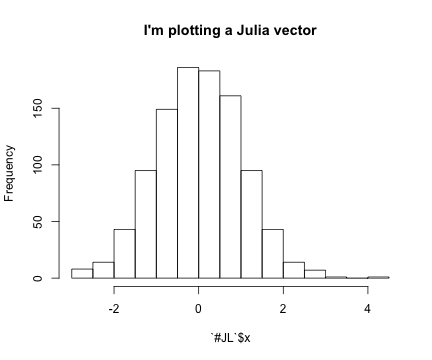

RCall.RObject{RCall.VecSxp}
$breaks
 [1] -3.0 -2.5 -2.0 -1.5 -1.0 -0.5  0.0  0.5  1.0  1.5  2.0  2.5  3.0  3.5  4.0
[16]  4.5

$counts
 [1]   8  14  43  95 149 186 183 161  95  43  14   7   1   0   1

$density
 [1] 0.016 0.028 0.086 0.190 0.298 0.372 0.366 0.322 0.190 0.086 0.028 0.014
[13] 0.002 0.000 0.002

$mids
 [1] -2.75 -2.25 -1.75 -1.25 -0.75 -0.25  0.25  0.75  1.25  1.75  2.25  2.75
[13]  3.25  3.75  4.25

$xname
[1] "`#JL`$x"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"


In [7]:
# Pkg.add("RCall")
using RCall

# Julia vector x is interpolated into R workspace
x = randn(1000)
R"""
hist($x, main="I'm plotting a Julia vector")
"""

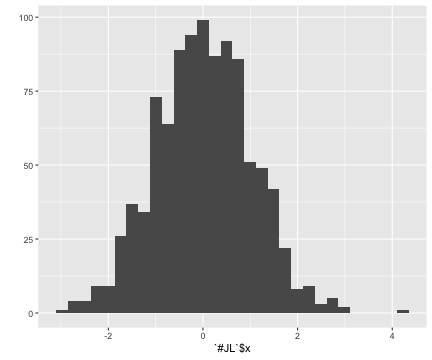

RCall.RObject{RCall.VecSxp}


In [8]:
R"""
library(ggplot2)
qplot($x)
"""

In [9]:
# wrapper of R variable(s)
x = R"""
rnorm(10)
"""

RCall.RObject{RCall.RealSxp}
 [1] -0.1301079 -0.7545138  1.2753783 -1.5666284 -0.2489429  0.2252800
 [7] -0.9252990  1.1762613 -2.8320719 -0.1904466


In [10]:
# convert it into Julia variable
y = collect(x)

10-element Array{Float64,1}:
 -0.130108
 -0.754514
  1.27538 
 -1.56663 
 -0.248943
  0.22528 
 -0.925299
  1.17626 
 -2.83207 
 -0.190447

* Access Julia variables in R REPL mode:
```julia
julia> x = rand(5) # Julia variable
R> y <- $x
```

* Pass Julia expression in R REPL mode:
```julia
R> y <- $(rand(5))
```

* Put Julia variable into R environment:
```julia
julia> @rput x
R> x
```

* Get R variable into Julia environment:
```julia
R> r <- 2
Julia> @rget r
```

* If you want to call Julia within R, check out the [`XRJulia`](https://cran.r-project.org/web/packages/XRJulia/) package by John Chambers.

## Some basic Julia code

In [11]:
y = 1
typeof(y) # same as int in R

Int64

In [12]:
y = 1.0
typeof(y) # same as double in R

Float64

In [13]:
# Greek letters:  `\pi<tab>`
π

π = 3.1415926535897...

In [14]:
# Greek letters:  `\theta<tab>`
θ = y + π

4.141592653589793

In [15]:
# emoji! `\:kissing_cat:<tab>`
😽 = 5.0

5.0

In [16]:
# wear a hat: `\alpha<tab>\hat<tab>`
α̂ = π

π = 3.1415926535897...

In [17]:
# vector of Float64 0s
x = zeros(5)

5-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0

In [18]:
# vector of Int64 0s
x = zeros(Int, 5)

5-element Array{Int64,1}:
 0
 0
 0
 0
 0

In [19]:
# matrix of Float64 0s
x = zeros(5, 3)

5×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [20]:
# matrix of Float64 1s
x = ones(5, 3)

5×3 Array{Float64,2}:
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0

In [21]:
# define array without initialization
x = Array{Float64}(5, 3)

5×3 Array{Float64,2}:
 2.29414e-314  2.29415e-314  0.0         
 0.0           2.29414e-314  2.29415e-314
 2.29415e-314  0.0           2.29414e-314
 2.29414e-314  2.29415e-314  0.0         
 0.0           2.29414e-314  2.29415e-314

In [22]:
# fill an array by 0s
fill!(x, 0)

5×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [23]:
# initialize an array to be 2.5
fill(2.5, (5, 3))

5×3 Array{Float64,2}:
 2.5  2.5  2.5
 2.5  2.5  2.5
 2.5  2.5  2.5
 2.5  2.5  2.5
 2.5  2.5  2.5

In [24]:
a = 3//5

3//5

In [25]:
typeof(a)

Rational{Int64}

In [26]:
b = 3//7
a + b

36//35

## Random numbers

In [27]:
# set random seed
srand(2018)

MersenneTwister(UInt32[0x000007e2], Base.dSFMT.DSFMT_state(Int32[-202096972, 1073008071, 2126042476, 1072793678, -64266256, 1072791560, -862800465, 1073689841, -1825118558, 1073580158  …  1117634044, 1073654874, -1803952621, 1073214982, 870324007, 762330074, 800503355, 556564238, 382, 0]), [1.07103, 1.72268, 1.75562, 1.37504, 1.07396, 1.42315, 1.09577, 1.33085, 1.13527, 1.12289  …  1.94222, 1.48013, 1.4621, 1.1817, 1.03535, 1.30246, 1.7705, 1.36516, 1.86276, 1.46612], 382)

In [28]:
# uniform [0, 1) random numbers
x = rand(5, 3)

5×3 Array{Float64,2}:
 0.654539  0.682842  0.356495
 0.108906  0.151455  0.260692
 0.723586  0.612651  0.970956
 0.720367  0.982534  0.966637
 0.262428  0.75867   0.34616 

In [29]:
# uniform random numbers (in single precision)
x = rand(Float16, 5, 3)

5×3 Array{Float16,2}:
 0.032227  0.89746  0.40625
 0.075195  0.96875  0.50391
 0.78906   0.78027  0.5293 
 0.095703  0.38672  0.55273
 0.15234   0.36621  0.79395

In [30]:
# random numbers from {1,...,5}
x = rand(1:5, 5, 3)

5×3 Array{Int64,2}:
 5  2  1
 5  1  4
 3  2  2
 5  3  2
 3  5  1

In [31]:
# standard normal random numbers
x = randn(5, 3)

5×3 Array{Float64,2}:
  0.56144     0.403827  -0.133275 
  0.0981954  -0.665607   0.0685784
  0.588447    1.01008    0.854076 
 -0.112509    0.898838  -0.837714 
 -0.120294    1.49929    0.27118  

## Timing and benchmark

`@time`, `@elapsed`, `@allocated` macros:

In [32]:
srand(123) # seed
x = randn(10000)
@time sum(x) # first run includes compilation time
@time sum(x) # no compilation time after first run

117.13472277852794

In [33]:
@elapsed sum(x)

1.0576e-5

In [34]:
@allocated sum(x)

16

Use `BenchmarkTools.jl` for more robust benchmarking. Analog of `microbenchmark` package in R.

In [35]:
using BenchmarkTools

@benchmark sum(x)

BenchmarkTools.Trial: 
  memory estimate:  16 bytes
  allocs estimate:  1
  --------------
  minimum time:     2.580 μs (0.00% GC)
  median time:      2.807 μs (0.00% GC)
  mean time:        2.870 μs (0.00% GC)
  maximum time:     13.801 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     9

  0.032879 seconds (9.88 k allocations: 546.020 KiB)
  0.000007 seconds (5 allocations: 176 bytes)


In [36]:
R"""
library(microbenchmark)
microbenchmark(sum($x))
"""

RCall.RObject{RCall.VecSxp}
Unit: microseconds
         expr    min      lq     mean median      uq    max neval
 sum(`#JL`$x) 14.073 14.5725 17.58876 15.802 17.3105 46.052   100


Why is R ~3-4 folder slower than Julia?

## Machine information

In [37]:
versioninfo()

Julia Version 0.6.4
Commit 9d11f62bcb (2018-07-09 19:09 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin14.5.0)
  CPU: Intel(R) Core(TM) i7-6920HQ CPU @ 2.90GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell MAX_THREADS=16)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.9.1 (ORCJIT, skylake)
